<a href="https://colab.research.google.com/github/Shoheli24/Traffic/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("NumPy:", np.__version__, "| Pandas:", pd.__version__)


NumPy: 2.0.2 | Pandas: 2.2.2


In [3]:

csv_path = "/content/traffic.csv"
assert os.path.exists(csv_path), "traffic.csv not found. Upload it to the working directory."
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head(10)


Shape: (48120, 4)


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


In [4]:
na_summary = df.isna().sum().sort_values(ascending=False)
display(na_summary.to_frame('missing_count'))

for col in df.columns:
    if df[col].isna().sum() == 0:
        continue
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col].fillna(df[col].median(), inplace=True)
    else:
        mode = df[col].mode()
        df[col].fillna(mode.iloc[0] if len(mode) else "Unknown", inplace=True)

print("✅ Missing values handled.")


,missing_count
DateTime,0
Junction,0
Vehicles,0
ID,0


✅ Missing values handled.


In [5]:
dt_candidates = [c for c in df.columns if any(k in c.lower() for k in ['date_time','datetime','timestamp','date'])]
dt_col = dt_candidates[0] if dt_candidates else None

if dt_col is None:
    dt_col = 'date_time'
    df[dt_col] = pd.date_range(start='2012-01-01', periods=len(df), freq='H')

df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce').interpolate().bfill().ffill()
df['Hour']      = df[dt_col].dt.hour
df['DayOfWeek'] = df[dt_col].dt.day_name()
df['Weekend']   = (df[dt_col].dt.weekday >= 5).astype(int)
print("✅ Derived features created.")


✅ Derived features created.


Target guessed: ID


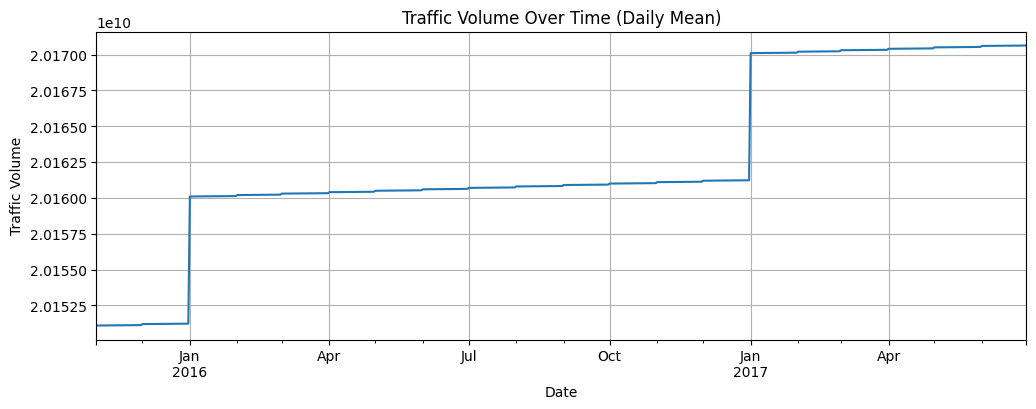

In [16]:

tgt_col = None
for name in ['traffic_volume','Traffic_Volume','Traffic Volume','volume','Volume','target']:
    if name in df.columns:
        tgt_col = name; break
if tgt_col is None:
    num_cols = [c for c in df.select_dtypes(include='number').columns if c not in ['Hour','Weekend']]
    tgt_col = df[num_cols].var().sort_values(ascending=False).index[0]
    print("Target guessed:", tgt_col)

plt.figure(figsize=(12,4))
(df.set_index(df[dt_col])[tgt_col]
   .resample('D').mean()
   .plot())
plt.title('Traffic Volume Over Time (Daily Mean)')
plt.xlabel('Date'); plt.ylabel('Traffic Volume'); plt.grid(True); plt.show()


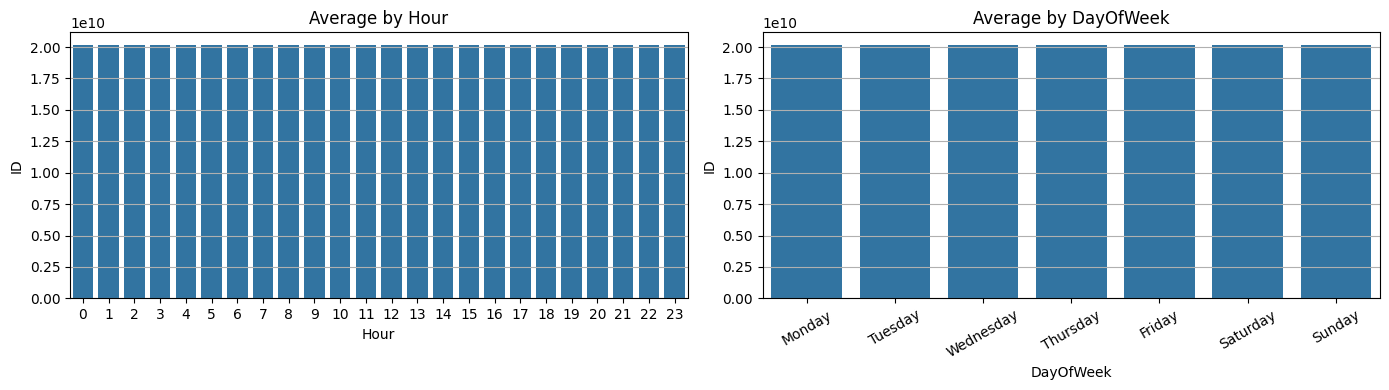

In [17]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

sns.barplot(ax=ax[0], data=df, x='Hour', y=tgt_col, estimator=np.mean, errorbar=None)
ax[0].set_title('Average by Hour'); ax[0].grid(True, axis='y')

order_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.barplot(ax=ax[1], data=df, x='DayOfWeek', y=tgt_col, order=order_days, estimator=np.mean, errorbar=None)
ax[1].set_title('Average by DayOfWeek'); ax[1].tick_params(axis='x', rotation=30); ax[1].grid(True, axis='y')

plt.tight_layout(); plt.show()


In [18]:
df_sorted = df.sort_values(by=dt_col).reset_index(drop=True)
split_idx = int(len(df_sorted)*0.8)
train_df, test_df = df_sorted.iloc[:split_idx].copy(), df_sorted.iloc[split_idx:].copy()

feature_cols = [c for c in df.columns if c not in [tgt_col, dt_col]]
num_features = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_features = [c for c in feature_cols if c not in num_features]

X_train, y_train = train_df[feature_cols], train_df[tgt_col].values
X_test,  y_test  = test_df[feature_cols],  test_df[tgt_col].values

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='drop'
)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (38496, 5)  Test: (9624, 5)


In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


linreg = Pipeline([('pre', preprocessor), ('model', LinearRegression())])
linreg.fit(X_train, y_train)

pred_lr = linreg.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
r2_lr   = r2_score(y_test, pred_lr)

print(f"Linear Regression — RMSE: {rmse_lr:.3f} | R²: {r2_lr:.3f}")


Linear Regression — RMSE: 6921082.840 | R²: -5297.281


In [20]:

rf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf   = r2_score(y_test, pred_rf)

print(f"Random Forest — RMSE: {rmse_rf:.3f} | R²: {r2_rf:.3f}")


Random Forest — RMSE: 4538566.385 | R²: -2277.370


In [12]:
results = pd.DataFrame([
    {"Model": "Linear Regression", "RMSE": rmse_lr, "R²": r2_lr},
    {"Model": "Random Forest",     "RMSE": rmse_rf, "R²": r2_rf},
])
results.sort_values("RMSE")


,Model,RMSE,R²
1,Random Forest,4.538566e+06,-2277.369917
0,Linear Regression,6.921083e+06,-5297.280518


In [21]:
best_pred = pred_rf if rmse_rf <= rmse_lr else pred_lr
best_name = "Random Forest" if rmse_rf <= rmse_lr else "Linear Regression"
print("Best model:", best_name)

test_with_pred = test_df.copy()
test_with_pred["pred"] = best_pred

(test_with_pred.groupby("Hour")["pred"]
 .mean()
 .sort_values(ascending=False)
 .head(3)
 .to_frame("avg_predicted_volume"))


Best model: Random Forest


,avg_predicted_volume
Hour,
23,2.016809e+10
8,2.016801e+10
1,2.016790e+10


In [22]:

ohe = rf.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_out = ohe.get_feature_names_out(cat_features).tolist()
feature_names = num_features + cat_out

rf_model = rf.named_steps["model"]
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

imp_df.head(15)


,feature,importance
1,Vehicles,0.392815
0,Junction,0.269486
2,Hour,0.206951
3,Weekend,0.052214
5,DayOfWeek_Monday,0.014539
4,DayOfWeek_Friday,0.014398
10,DayOfWeek_Wednesday,0.010963
8,DayOfWeek_Thursday,0.010873
9,DayOfWeek_Tuesday,0.010511
7,DayOfWeek_Sunday,0.009829


In [23]:
test_with_pred["abs_err"] = (test_with_pred["pred"] - test_with_pred[tgt_col]).abs()
worst = test_with_pred.sort_values("abs_err", ascending=False).head(1)

worst[[dt_col] + feature_cols + [tgt_col, "pred", "abs_err"]]


,DateTime,Junction,Vehicles,Hour,DayOfWeek,Weekend,ID,pred,abs_err
43902,2017-05-18 01:00:00,3,4,1,Thursday,0,20170518013,2.015318e+10,1.733773e+07
